In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
# sns.set_style()
# sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [2]:
tasks = ['hospital_mortality', 'sepsis', 'LOS_7', 'readmission_30','aki_lab_aki3_label','hyperkalemia_lab_severe_label','hypoglycemia_lab_severe_label','hyponatremia_lab_severe_label','neutropenia_lab_severe_label','anemia_lab_severe_label','thrombocytopenia_lab_severe_label']

metrics = ['auc', 'auprc', 'ace_abs_logistic_logit']
model_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/models'
results_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/results'
figure_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/notebooks/figures'

best_clmbr_params = {'all':'gru_sz_800_do_0_lr_0.0001_l2_0', 'mix':'gru_sz_800_do_0_lr_0.0001_l2_0'}

models = ['lr']
feat_groups = ['shared', 'pediatric', 'adult']
cohort_types = ['pediatric', 'adult']

titles = {
    'hospital_mortality':'In-hospital Mortality', 
    'sepsis':'SEPSIS-3', 
    'LOS_7':'Length of Stay > 7 days', 
    'readmission_30':'Readmission after 30 days', 
    'aki_lab_abnormal_label':'Abnormal Acute Kidney Injury',
    'aki_lab_aki1_label':'Acute Kidney Injury 1',
    'aki_lab_aki2_label':'Acute Kidney Injury 2',
    'aki_lab_aki3_label':'Acute Kidney Injury 3',
    'hyperkalemia_lab_abnormal_label':'Abnormal Hyperkalemia',
    'hyperkalemia_lab_mild_label':'Mild Hyperkalemia',
    'hyperkalemia_lab_moderate_label':'Moderate Hyperkalemia',
    'hyperkalemia_lab_severe_label':'Severe Hyperkalemia',
    'hypoglycemia_lab_abnormal_label':'Abnormal Hypoglycemia',
    'hypoglycemia_lab_mild_label': 'Mild Hypoglycemia',
    'hypoglycemia_lab_moderate_label':'Moderate Hypoglycemia',
    'hypoglycemia_lab_severe_label':'Severe Hypoglycemia',
    'hyponatremia_lab_abnormal_label':'Abnormal Hyponatremia',
    'hyponatremia_lab_mild_label':'Mild Hyponatremia',
    'hyponatremia_lab_moderate_label':'Moderate Hyponatremia',
    'hyponatremia_lab_severe_label':'Severe Hyponatremia',
    'neutropenia_lab_mild_label':'Mild Neutropenia',
    'neutropenia_lab_moderate_label':'Moderate Neutropenia',
    'neutropenia_lab_severe_label':'Severe Neutropenia',
    'anemia_lab_abnormal_label':'Abnormal Anemia',
    'anemia_lab_mild_label':'Mild Anemia',
    'anemia_lab_moderate_label':'Moderate Anemia',
    'anemia_lab_severe_label':'Severe Anemia',
    'thrombocytopenia_lab_abnormal_label':'Abnormal Thrombocytopenia',
    'thrombocytopenia_lab_mild_label':'Mild Thrombocytopenia',
    'thrombocytopenia_lab_moderate_label':'Moderate Thrombocytopenia',
    'thrombocytopenia_lab_severe_label':'Severe Thrombocytopenia'
    }

In [24]:
# group tasks by overlying group, average performance within group
# rename some abnormal labels
# statistical delta comparisons between models
# look at severe labels only

dict_values(['In-hospital Mortality', 'SEPSIS-3', 'Length of Stay > 7 days', 'Readmission after 30 days', 'Abnormal Acute Kidney Injury', 'Acute Kidney Injury 1', 'Acute Kidney Injury 2', 'Acute Kidney Injury 3', 'Abnormal Hyperkalemia', 'Mild Hyperkalemia', 'Moderate Hyperkalemia', 'Severe Hyperkalemia', 'Abnormal Hypoglycemia', 'Mild Hypoglycemia', 'Moderate Hypoglycemia', 'Severe Hypoglycemia', 'Abnormal Hyponatremia', 'Mild Hyponatremia', 'Moderate Hyponatremia', 'Severe Hyponatremia', 'Mild Neutropenia', 'Moderate Neutropenia', 'Severe Neutropenia', 'Abnormal Anemia', 'Mild Anemia', 'Moderate Anemia', 'Severe Anemia', 'Abnormal Thrombocytopenia', 'Mild Thrombocytopenia', 'Moderate Thrombocytopenia', 'Severe Thrombocytopenia'])


In [4]:
y_axis = {
    'auc':{
        'lim':[-0.35,0.1],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[-0.32,0.18],
        'label':'AUPRC_C'
    },
    'ace_abs_logistic_logit':{
        'lim':[-0.02, 0.15],
        'label':'ACE'
    }
}

model_colours = {
    # rename to model names and use as boxplot face colours
    'Count-LR_Target':'purple',
    'Count-LR_Target[Constrained]':'pink',
    'Count-LR_Source':'blue',
    'CLMBR_Source':'lightgreen',
    'CLMBR_Target':'red',
    'CLMBR_Source[Adult]':'yellow',
    'CLMBR_FT-Pre':'green',
    'CLMBR_FT-Pre[Constrained]':'turquoise',
    'CLMBR_FT-Pre[Adult]':'brown',
    'Count-LR_Ft-Task':'lightblue'
}


task_colours = {    
    # mortality / ADT
    'sepsis':'olive', # different than the rest 
    'hospital_mortality':'black', #dark grey    
    'LOS_7':'grey', # another grey    
    'readmission_30':'lightgrey', #light gray       
    # Chemistry    
    'aki_lab_aki3_label':'steelblue',
    'hyperkalemia_lab_severe_label':'dodgerblue',    
    'hypoglycemia_lab_severe_label':'darkturquoise',    
    'hyponatremia_lab_severe_label':'deepskyblue', 
    # Cytopenia
    'neutropenia_lab_severe_label':'orangered',
    'anemia_lab_severe_label':'salmon',      
    'thrombocytopenia_lab_severe_label':'tomato', 
}
# task_colours = {titles[k]:v for k,v in task_colours.items()}

In [5]:
palette_list = [task_colours[task] for task in tasks]
print(palette_list)
task_palette = sns.color_palette(palette_list)

['black', 'olive', 'grey', 'lightgrey', 'steelblue', 'dodgerblue', 'darkturquoise', 'deepskyblue', 'orangered', 'salmon', 'tomato']


In [18]:
print(sns.color_palette("dark:turquoise_r").as_hex())

['#40e0d0', '#3abbae', '#34968c', '#2e716a', '#284c48', '#232726']


In [19]:
sns.color_palette("dark:turquoise_r")

[(0.25098039215686274, 0.8784313725490196, 0.8156862745098039),
 (0.22791069663341962, 0.7329520483584387, 0.6822653880646042),
 (0.2048410011099765, 0.5874727241678579, 0.5488445016194046),
 (0.18177130558653337, 0.4419933999772772, 0.41542361517420495),
 (0.15870161006309025, 0.2965140757866963, 0.28200272872900534),
 (0.13563191453964715, 0.15103475159611557, 0.1485818422838057)]

In [174]:
print(sns.color_palette().as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


In [6]:
model_palette_list = [model_colours[k] for k in model_colours.keys()]

In [29]:
# Get baseline model
lr_df = pd.DataFrame()
print('LR')
for task in tasks:
    for trc in ['adult', 'pediatric', 'constrain']:
        for tstc in ['pediatric', 'adult']:
            for fg in feat_groups:
                df = pd.read_csv(f'{results_path}/lr/{task}/tr_{trc}_tst_{tstc}/shared_feats/best/test_eval.csv')
                df['task'] = task
                df['train_cohort'] = trc
                df['test_cohort'] = tstc
                df['cohort'] = trc
                df['model'] = 'LR'
                df['feature_group'] = fg
                lr_df = pd.concat([lr_df,df])

# ft_lr_df = pd.DataFrame()
# for task in tasks:
#     for trc in ['adult', 'pediatric']:
#         for tstc in ['pediatric']: # 'adult']:
#             for fg in feat_groups:
#                 df = pd.read_csv(f'{results_path}/lr_ft/{task}/tr_{trc}_tst_{tstc}/shared_feats/best/test_eval.csv')
#                 df['task'] = task
#                 df['cohort'] = ct
#                 df['model'] = 'FT-LR'
#                 df['feature_group'] = fg
#                 ft_lr_df = pd.concat([ft_lr_df,df])

# pt_gbm_df = pd.DataFrame()
# for ct in cohort_types:
#     for task in tasks:
#         for fg in feat_groups:
#             df = pd.read_csv(f'{results_path}/{ct}/gbm/{task}/{fg}_feats/best/test_eval.csv')
#             df['task'] = task
#             df['cohort'] = ct
#             df['model'] = 'PT-GBM'
#             df['feature_group'] = fg
#             pt_gbm_df = pd.concat([pt_gbm_df,df])
            
# ft_gbm_df = pd.DataFrame()
# for ct in ['adult']:
#     for task in tasks:
#         for fg in feat_groups:
#             df = pd.read_csv(f'{results_path}/{ct}/gbm_ft/{task}/{fg}_feats/best/test_eval.csv')
#             df['task'] = task
#             df['cohort'] = ct
#             df['model'] = 'FT-GBM'
#             df['feature_group'] = fg
#             ft_gbm_df = pd.concat([ft_gbm_df,df])
print('PED CLMBR')
ped_clmbr_df = pd.DataFrame()
for task in tasks:
    for ct in ['ped']:
        for tr_cht in ['ped']:
            for tst_cht in ['ped']:
                for lr in ['0.0001']:
                    try:
                        df = pd.read_csv(f'{results_path}/clmbr/pretrained/{ct}/{task}/tr_{tr_cht}_tst_{tst_cht}/gru_sz_800_do_0_lr_{lr}_l2_0/test_eval.csv')
                        df['task'] = task
                        df['cohort'] = ct
                        df['train_adapter'] = tr_cht
                        df['test_adapter'] = tst_cht
                        df['model'] = 'CLMBR_Target'
                        ped_clmbr_df = pd.concat([ped_clmbr_df,df])
                    except:
                        print(f'missing {ct} {tst_cht} {task} eval')
print('AD CLMBR')
ad_clmbr_df = pd.DataFrame()
for task in tasks:
    for ct in ['ad']:
        for tr_cht in ['ad']:
            for tst_cht in ['ad','ped']:
                for lr in ['0.0001']:
                    try:
                        df = pd.read_csv(f'{results_path}/clmbr/pretrained/{ct}/{task}/tr_{tr_cht}_tst_{tst_cht}/gru_sz_800_do_0_lr_{lr}_l2_0/test_eval.csv')
                        df['task'] = task
                        df['cohort'] = ct
                        df['train_adapter'] = tr_cht
                        df['test_adapter'] = tst_cht
                        df['model'] = 'CLMBR_Source[Adult]'
                        ad_clmbr_df = pd.concat([ad_clmbr_df,df])
                    except:
                        print(f'missing {ct} {tst_cht} {task} eval')
print('ALL CLMBR')
all_clmbr_df = pd.DataFrame()
for task in tasks:
    for ct in ['all']:
        for tr_cht in ['ad', 'ped']:
            for tst_cht in ['ped', 'ad']:
                for lr in ['0.0001']:
                    try:
                        df = pd.read_csv(f'{results_path}/clmbr/pretrained/{ct}/{task}/tr_{tr_cht}_tst_{tst_cht}/gru_sz_800_do_0_lr_{lr}_l2_0/test_eval.csv')
                        df['task'] = task
                        df['cohort'] = ct
                        df['train_adapter'] = tr_cht
                        df['test_adapter'] = tst_cht
                        df['model'] = 'CLMBR_Source'
                        all_clmbr_df = pd.concat([all_clmbr_df,df])
                    except:
                        print(f'missing {ct} {tst_cht} {task} eval')
print('Ft-Pre CLMBR')
ftp_clmbr_df = pd.DataFrame()
for task in tasks:
    for ct in ['all']:
        for tr_cht in ['ped']:
            for tst_cht in ['ped']:
                for lr in ['0.0001']:
                    try:
                        df = pd.read_csv(f'{results_path}/clmbr/finetuned/{ct}/{task}/tr_{tr_cht}_tst_{tst_cht}/gru_sz_800_do_0_lr_{lr}_l2_0/test_eval.csv')
                        df['task'] = task
                        df['cohort'] = ct
                        df['train_adapter'] = tr_cht
                        df['test_adapter'] = tst_cht
                        df['model'] = 'CLMBR_FT-Pre'
                        ftp_clmbr_df = pd.concat([ftp_clmbr_df,df])
                    except:
                        print(f'missing {tst_cht} {task} eval')
print('Ft-Pre CLMBR[Constrained]')
cons_ftp_clmbr_df = pd.DataFrame()
for task in tasks:
    for ct in ['all']:
        for tr_cht in ['constrain']:
            for tst_cht in ['ped']:
                for lr in ['0.0001']:
                    try:
                        df = pd.read_csv(f'{results_path}/clmbr/finetuned/{ct}/{task}/tr_{tr_cht}_tst_{tst_cht}/gru_sz_800_do_0_lr_{lr}_l2_0/test_eval.csv')
                        df['task'] = task
                        df['cohort'] = ct
                        df['train_adapter'] = tr_cht
                        df['test_adapter'] = tst_cht
                        df['model'] = 'CLMBR_FT-Pre[Constrained]'
                        cons_ftp_clmbr_df = pd.concat([cons_ftp_clmbr_df,df])
                    except:
                        print(f'missing {tst_cht} {task} eval')
print('FT-Pre[Adult]')
ad_ftp_clmbr_df = pd.DataFrame()
for task in tasks:
    for ct in ['ad']:#, 'ad']:#,  'ad', 'ped']:
        for tr_cht in ['ped']:
            for tst_cht in ['ped']:
                for lr in ['0.0001']:#, '1e-5']:
                    try:
                        df = pd.read_csv(f'{results_path}/clmbr/finetuned/{ct}/{task}/tr_{tr_cht}_tst_{tst_cht}/gru_sz_800_do_0_lr_{lr}_l2_0/test_eval.csv')
                        df['task'] = task
                        df['cohort'] = ct
                        df['train_adapter'] = tr_cht
                        df['test_adapter'] = tst_cht
                        df['model'] = 'CLMBR_FT-Pre[Adult]'
                        ad_ftp_clmbr_df = pd.concat([ad_ftp_clmbr_df,df])
                    except:
                        print(f'missing {ct} {tst_cht} {task} eval')
                
all_clmbr_df = all_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})
ftp_clmbr_df = ftp_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})
cons_ftp_clmbr_df = cons_ftp_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})
ped_clmbr_df = ped_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})
ad_clmbr_df = ad_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})
ad_ftp_clmbr_df = ad_ftp_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})

LR
PED CLMBR
AD CLMBR
ALL CLMBR
missing all ad hospital_mortality eval
missing all ad sepsis eval
missing all ad LOS_7 eval
missing all ad readmission_30 eval
missing all ad aki_lab_aki3_label eval
missing all ad hyperkalemia_lab_severe_label eval
missing all ad hypoglycemia_lab_severe_label eval
missing all ad hyponatremia_lab_severe_label eval
missing all ad neutropenia_lab_severe_label eval
missing all ad anemia_lab_severe_label eval
missing all ad thrombocytopenia_lab_severe_label eval
Ft-Pre CLMBR
Ft-Pre CLMBR[Constrained]
FT-Pre[Adult]


In [30]:
ad_ftp_clmbr_df

,Unnamed: 0,metric,performance,model,task,cohort,train_adapter,test_adapter
0,0,auc,0.978674,CLMBR_FT-Pre[Adult],hospital_mortality,ad,ped,ped
1,1,auprc,0.296067,CLMBR_FT-Pre[Adult],hospital_mortality,ad,ped,ped
2,2,loss_bce,0.028577,CLMBR_FT-Pre[Adult],hospital_mortality,ad,ped,ped
3,3,ace_rmse_logistic_logit,0.013205,CLMBR_FT-Pre[Adult],hospital_mortality,ad,ped,ped
4,4,ace_abs_logistic_logit,0.001777,CLMBR_FT-Pre[Adult],hospital_mortality,ad,ped,ped
0,0,auc,0.898882,CLMBR_FT-Pre[Adult],sepsis,ad,ped,ped
1,1,auprc,0.263149,CLMBR_FT-Pre[Adult],sepsis,ad,ped,ped
2,2,loss_bce,0.088936,CLMBR_FT-Pre[Adult],sepsis,ad,ped,ped
3,3,ace_rmse_logistic_logit,0.012854,CLMBR_FT-Pre[Adult],sepsis,ad,ped,ped
4,4,ace_abs_logistic_logit,0.005776,CLMBR_FT-Pre[Adult],sepsis,ad,ped,ped


In [8]:
df = pd.DataFrame()
df = pd.concat((lr_df.query('feature_group=="shared"'),ped_clmbr_df,ad_clmbr_df,all_clmbr_df,ftp_clmbr_df, cons_ftp_clmbr_df, ad_ftp_clmbr_df)).drop(columns=['C','Unnamed: 0'])
df = df.replace({'task':{**titles}})
df.to_csv('deprecated/model_evals.csv', index=False)

In [ ]:
df = ft_gbm_df
for task in tasks:
    t_df = df.query("test_group=='test' and metric=='auc' and feature_group=='shared' and task==@task and cohort=='adult'")
    print(task)
    print(f"{round(t_df['CI_med'].values[0],3)}\n({round(t_df['CI_lower'].values[0],3)}, {round(t_df['CI_upper'].values[0],3)})")

In [ ]:
df = all_clmbr_df
for cohort in ['all']:# 'ad', 'ped']
    print(cohort)
    for task in tasks:
        t_df = df.query("metric=='auc' and task==@task and cohort==@cohort")
        print(task)
        print(f"{round(t_df['performance'][0], 3)}")


In [31]:
metrics = ['auc', 'auprc', 'ace_abs_logistic_logit']
scenarios = ['s1m', 's1s1', 's1s2', 's1s3', 's2m', 's2s1', 's2s2', 's3m', 's3s1']
plot_dict = {}
for s in scenarios:
    plot_dict[s] = {}
    for metric in metrics:
        plot_dict[s][metric] = pd.DataFrame()
        if s == 's1m': #Scenario 1 main figure looking at OOD performance between Count-LR_Source and CLMBR_Source
            lr_source = lr_df.query("train_cohort=='adult' and metric==@metric and feature_group=='shared' and metric==@metric and test_cohort=='pediatric'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':lr_source['performance'],'Tasks':lr_source['task'],'Model':'Count-LR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_source = all_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'Tasks':clmbr_source['task'],'Model':'CLMBR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
        elif s == 's1s1': # Scenario 1 supplementary 1 looking at ID performance of Count-LR_Source and CLMBR_Source
            
            lr_source = lr_df.query("train_cohort=='adult' and metric==@metric and feature_group=='shared' and metric==@metric and test_cohort=='adult'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':lr_source['performance'],'Tasks':lr_source['task'],'Model':'Count-LR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_source = all_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ad'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'Tasks':clmbr_source['task'],'Model':'CLMBR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
        
        elif s == 's1s2': # Scenario 1 supplementary 2 looking at OOD performance of CLMBR_Source vs CLMBR_Source[Adult] 
            
            clmbr_source = all_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'Tasks':clmbr_source['task'],'Model':'CLMBR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_adult = ad_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='ad' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_adult['performance'],'Tasks':clmbr_adult['task'],'Model':'CLMBR_Source[Adult]'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
        
        elif s == 's1s3': # Scenario 1 supplementary 3 looking at change in performance from ID to OOD for CLMBR_Source 
            
            clmbr_source = all_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'Tasks':clmbr_source['task'],'Model':'CLMBR_Source', 'Test':'ped'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_source = all_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ad'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'Tasks':clmbr_source['task'],'Model':'CLMBR_Source', 'Test':'ad'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
        elif s == 's2m':
            lr_bl = lr_df.query("train_cohort=='pediatric' and metric==@metric and feature_group=='shared' and metric==@metric and test_cohort=='pediatric'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':lr_bl['performance'],'Tasks':lr_bl['task'],'Model':'Count-LR_Target'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))

            clmbr_target = ped_clmbr_df.query("train_adapter=='ped' and metric==@metric and cohort=='ped' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_target['performance'],'Tasks':clmbr_target['task'],'Model':'CLMBR_Target'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))

            clmbr_source = all_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'Tasks':clmbr_source['task'],'Model':'CLMBR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))

            clmbr_ftp = ftp_clmbr_df.query("train_adapter=='ped' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_ftp['performance'],'Tasks':clmbr_ftp['task'],'Model':'CLMBR_FT-Pre'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
        elif s == 's2s1':
            lr_bl = lr_df.query("train_cohort=='pediatric' and metric==@metric and feature_group=='shared' and metric==@metric and test_cohort=='pediatric'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':lr_bl['performance'],'Tasks':lr_bl['task'],'Model':'Count-LR_Target'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))

            clmbr_target = ped_clmbr_df.query("train_adapter=='ped' and metric==@metric and cohort=='ped' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_target['performance'],'Tasks':clmbr_target['task'],'Model':'CLMBR_Target'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))

            clmbr_source = all_clmbr_df.query("train_adapter=='ped' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'Tasks':clmbr_source['task'],'Model':'CLMBR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))

            clmbr_ftp = ftp_clmbr_df.query("train_adapter=='ped' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_ftp['performance'],'Tasks':clmbr_ftp['task'],'Model':'CLMBR_FT-Pre'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
        elif s == 's2s2':
            clmbr_ftp = ftp_clmbr_df.query("train_adapter=='ped' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_ftp['performance'],'Tasks':clmbr_ftp['task'],'Model':'CLMBR_FT-Pre'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_ad_ftp = ad_ftp_clmbr_df.query("train_adapter=='ped' and metric==@metric and cohort=='ad' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_ad_ftp['performance'],'Tasks':clmbr_ad_ftp['task'],'Model':'CLMBR_FT-Pre[Adult]'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
        
        elif s == 's3m':
            
#             lr_bl = lr_df.query("train_cohort=='pediatric' and metric==@metric and feature_group=='shared' and metric==@metric and test_cohort=='pediatric'")[['performance', 'task']]
#             df = pd.DataFrame({'Performance':lr_bl['performance'],'Tasks':lr_bl['task'],'Model':'Count-LR_Target'})
#             plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            lr_bl = lr_df.query("train_cohort=='constrain' and metric==@metric and feature_group=='shared' and metric==@metric and test_cohort=='pediatric'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':lr_bl['performance'],'Tasks':lr_bl['task'],'Model':'Count-LR_Target[Constrained]'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_source = all_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'Tasks':clmbr_source['task'],'Model':'CLMBR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_ftp_cons = cons_ftp_clmbr_df.query("train_adapter=='constrain' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_ftp_cons['performance'],'Tasks':clmbr_ftp_cons['task'],'Model':'CLMBR_FT-Pre[Constrained]'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
        
            
        else:
            pass

In [205]:
print('OOD')
print(plot_dict['s1m']['auc'].query('task=="sepsis"')['Performance'])
print('ID')
print(plot_dict['s1s1']['auc'].query('task=="sepsis"')['Performance'])

OOD
0    0.700919
0    0.894898
Name: Performance, dtype: float64
ID
0    0.843349
0    0.932279
Name: Performance, dtype: float64


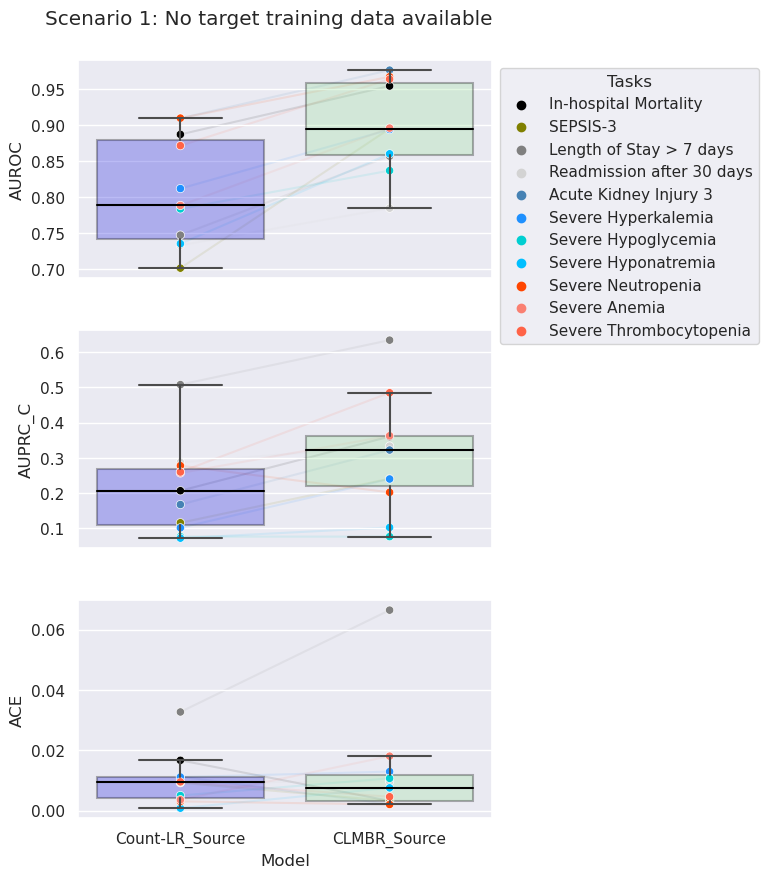

In [18]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(5,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Main figure for Scenario 1
fig.suptitle('Scenario 1: No target training data available ')
for r, metric in enumerate(metrics):
    df = plot_dict['s1m'][metric]

    df = df.replace({'Tasks':{**titles}})
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours)
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='Tasks',  palette=sns.color_palette(palette_list), ax=axs[r])

    lp = sns.lineplot(x="Model", y="Performance", hue='Tasks', data=df.reset_index(), palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r], zorder=0)
    
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != 0:
        sp.legend_.remove()
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])
        
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
# sp.fig.legend(h,l, ncol=6)
plt.savefig('figures/sc_1_main.png', bbox_inches='tight')

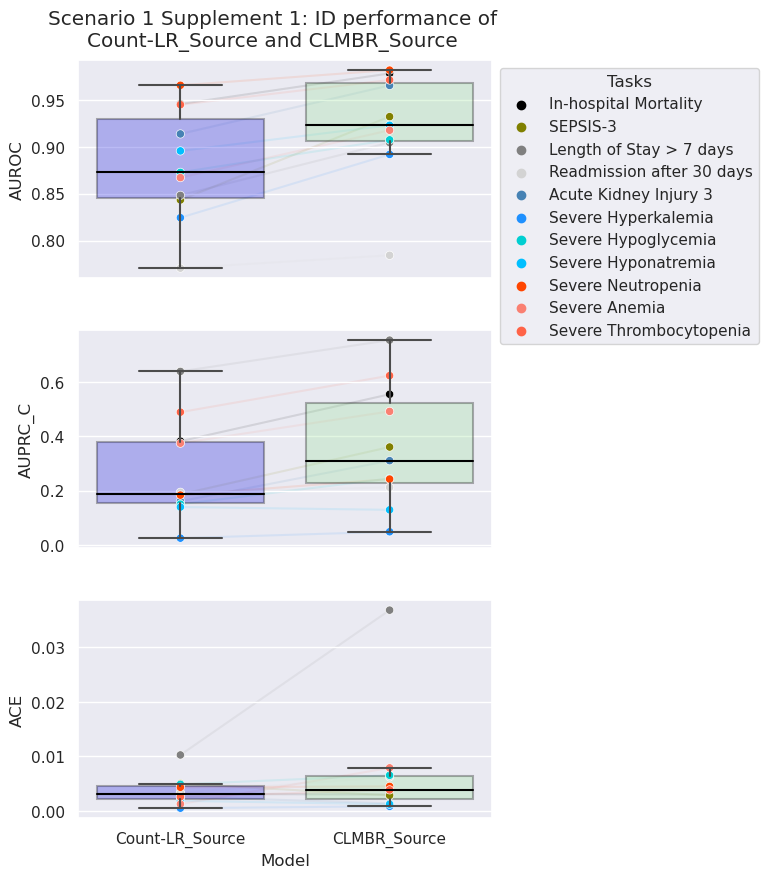

In [16]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(5,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Main figure for Scenario 1
fig.suptitle('Scenario 1 Supplement 1: ID performance of\nCount-LR_Source and CLMBR_Source')
for r, metric in enumerate(metrics):
    df = plot_dict['s1s1'][metric]
    df = df.replace({'Tasks':{**titles}})
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours) 
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='Tasks',  palette=sns.color_palette(palette_list), ax=axs[r])
    lp = sns.lineplot(x="Model", y="Performance", hue='Tasks', data=df.reset_index(), palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r], zorder=0)
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != 0:
        sp.legend_.remove()
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])
        
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
plt.savefig('figures/sc_1_supp_1.png', bbox_inches='tight')

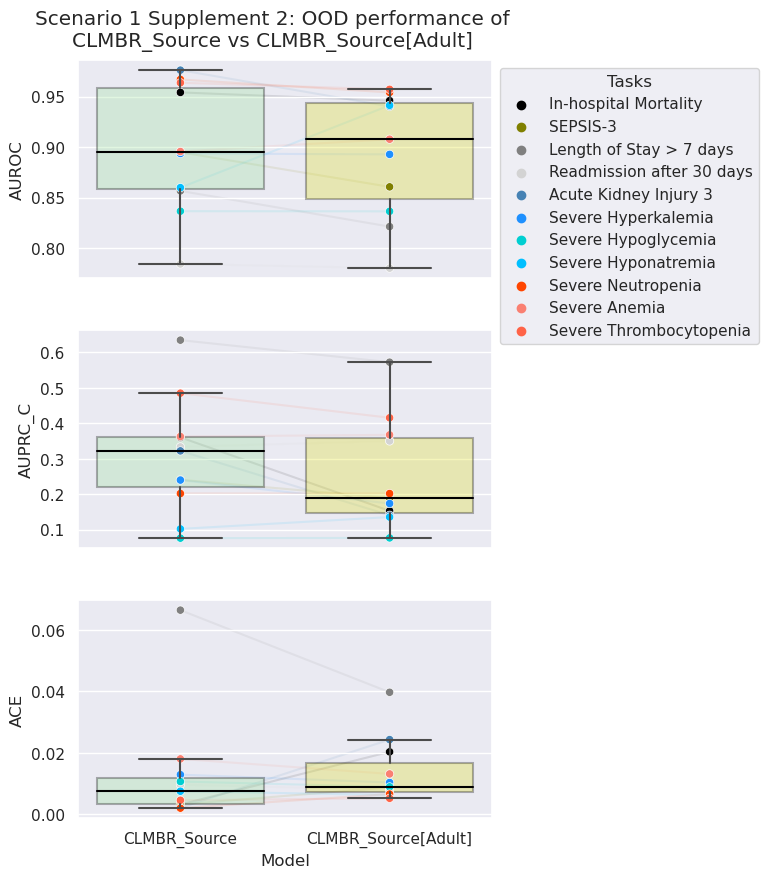

In [20]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(5,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Main figure for Scenario 1
fig.suptitle('Scenario 1 Supplement 2: OOD performance of\nCLMBR_Source vs CLMBR_Source[Adult]')
for r, metric in enumerate(metrics):
    df = plot_dict['s1s2'][metric]

    df = df.replace({'Tasks':{**titles}})
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours)
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='Tasks',  palette=sns.color_palette(palette_list), ax=axs[r])
    lp = sns.lineplot(x="Model", y="Performance", hue='Tasks', data=df.reset_index(), palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r], zorder=0)
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != 0:
        sp.legend_.remove()
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])
        
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
plt.savefig('figures/sc_1_supp_2.png', bbox_inches='tight')

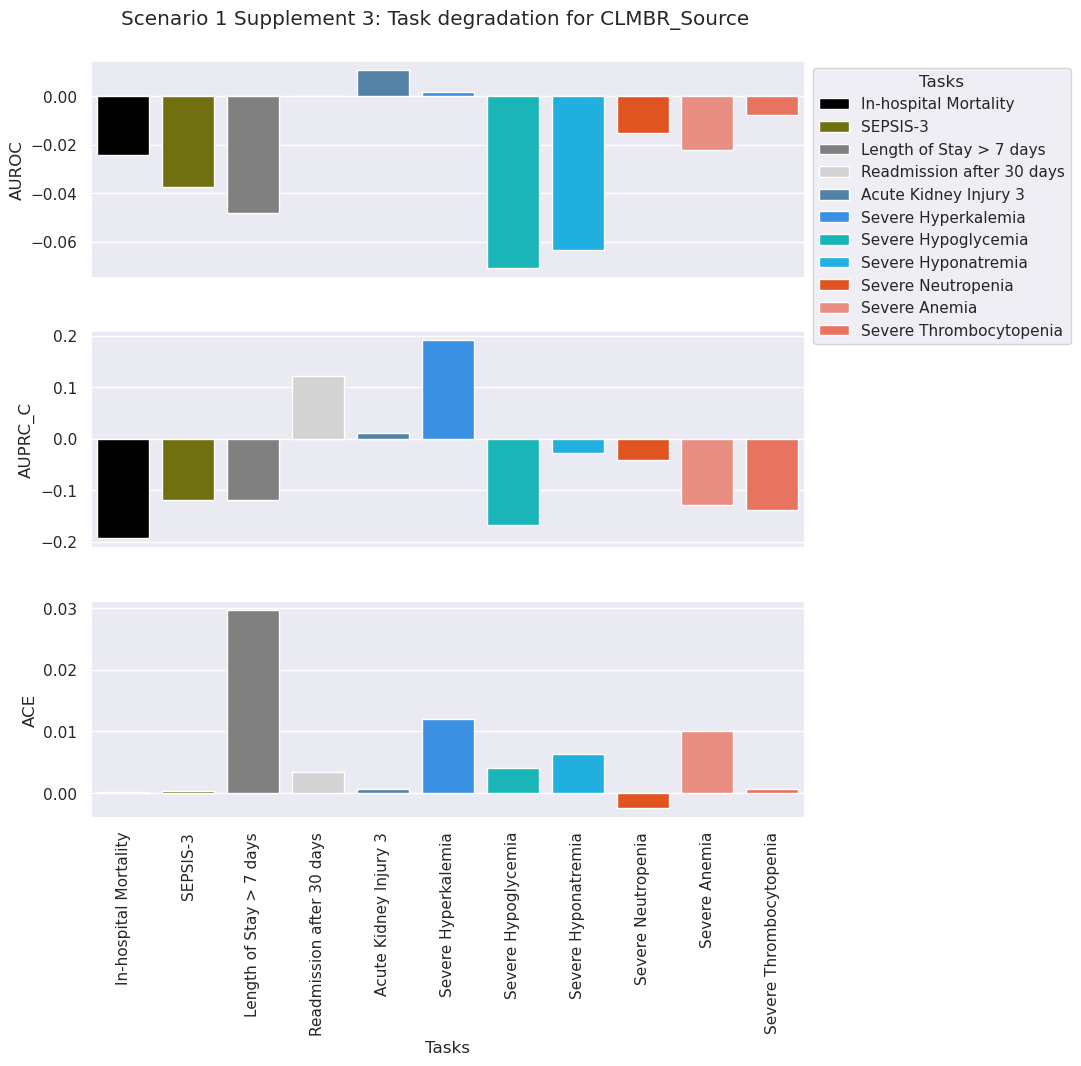

In [21]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(8,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Supplement 3b for Scenario 1, showing degradation across groups
fig.suptitle('Scenario 1 Supplement 3: Task degradation for CLMBR_Source')
for r, metric in enumerate(metrics):
    df = plot_dict['s1s3'][metric]
    df = df.replace({'Tasks':{**titles}})
    id_df = df.query('Test=="ad"')
    ood_df = df.query('Test=="ped"')
    df = id_df
    df['Performance'] = ood_df['Performance'] - id_df['Performance']
    bp = sns.barplot(x="Tasks", y="Performance", data=df,ax=axs[r],  hue="Tasks", palette=sns.color_palette(palette_list),dodge=False)
    
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != 0:
        bp.legend_.remove()
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])
axs[-1].tick_params(axis='x', rotation=90)
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
plt.savefig('figures/sc_1_supp_3b.png', bbox_inches='tight')

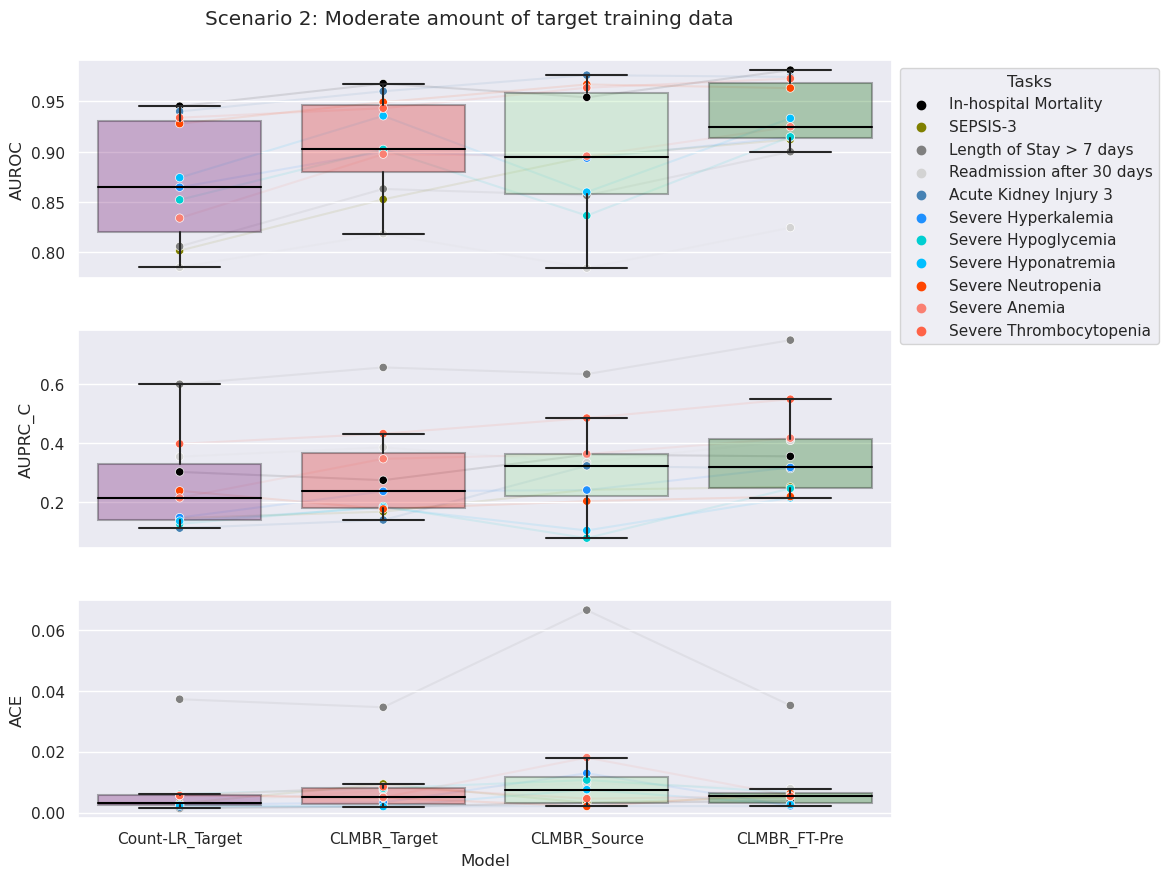

In [23]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(9,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Main figure for Scenario 1
fig.suptitle('Scenario 2: Moderate amount of target training data ')
for r, metric in enumerate(metrics):
    df = plot_dict['s2m'][metric]
    df = df.replace({'Tasks':{**titles}})
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours)
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='Tasks',  palette=sns.color_palette(palette_list), ax=axs[r])
    lp = sns.lineplot(x="Model", y="Performance", hue='Tasks', data=df.reset_index(), palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r], zorder=0)
    h,l = sp.axes.get_legend_handles_labels()
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != 0:
        sp.legend_.remove()
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])
        
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
plt.savefig('figures/sc_2_main.png', bbox_inches='tight')

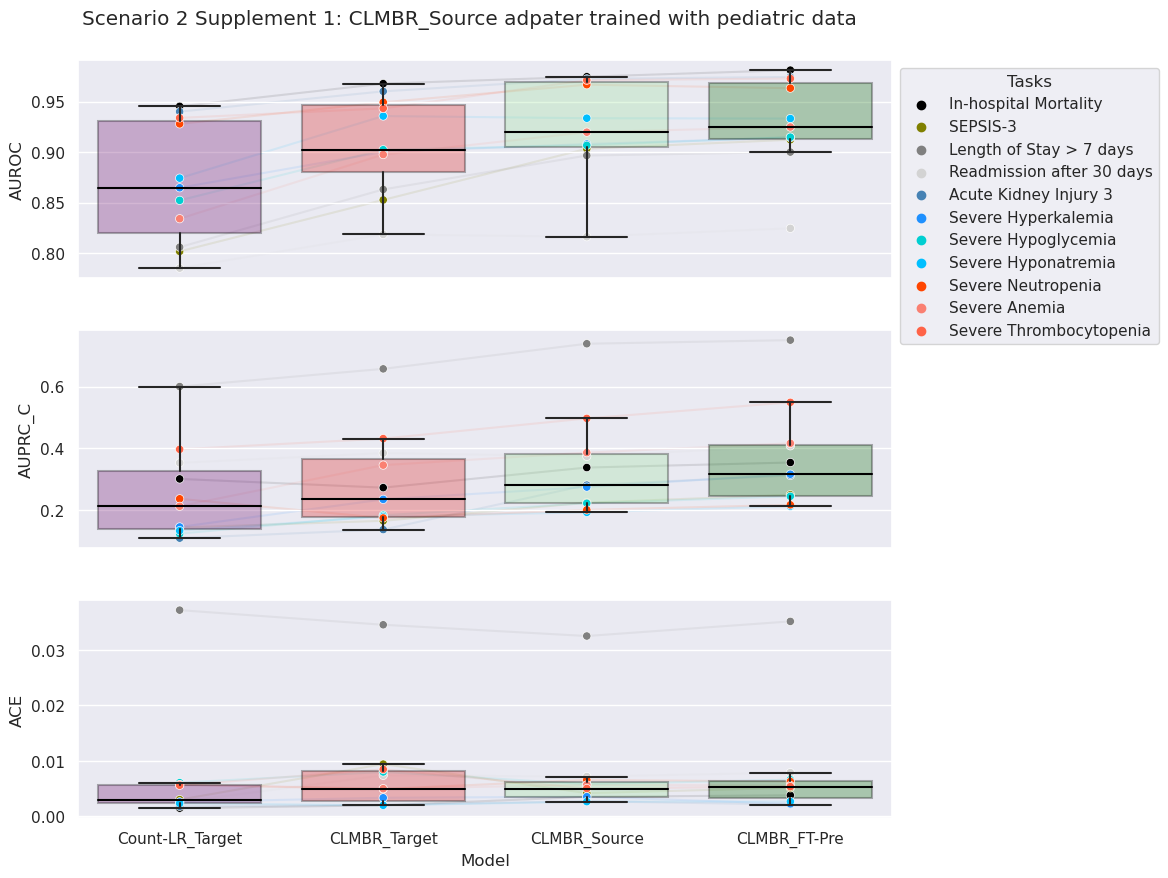

In [26]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(9,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Main figure for Scenario 1
fig.suptitle('Scenario 2 Supplement 1: CLMBR_Source adpater trained with pediatric data ')
for r, metric in enumerate(metrics):
    df = plot_dict['s2s1'][metric]
    df = df.replace({'Tasks':{**titles}})
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours)
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='Tasks',  palette=sns.color_palette(palette_list), ax=axs[r])
    lp = sns.lineplot(x="Model", y="Performance", hue='Tasks', data=df.reset_index(), palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r], zorder=0)
    h,l = sp.axes.get_legend_handles_labels()
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != 0:
        sp.legend_.remove()
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])
        
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
plt.savefig('figures/sc_2_supp_1.png', bbox_inches='tight')

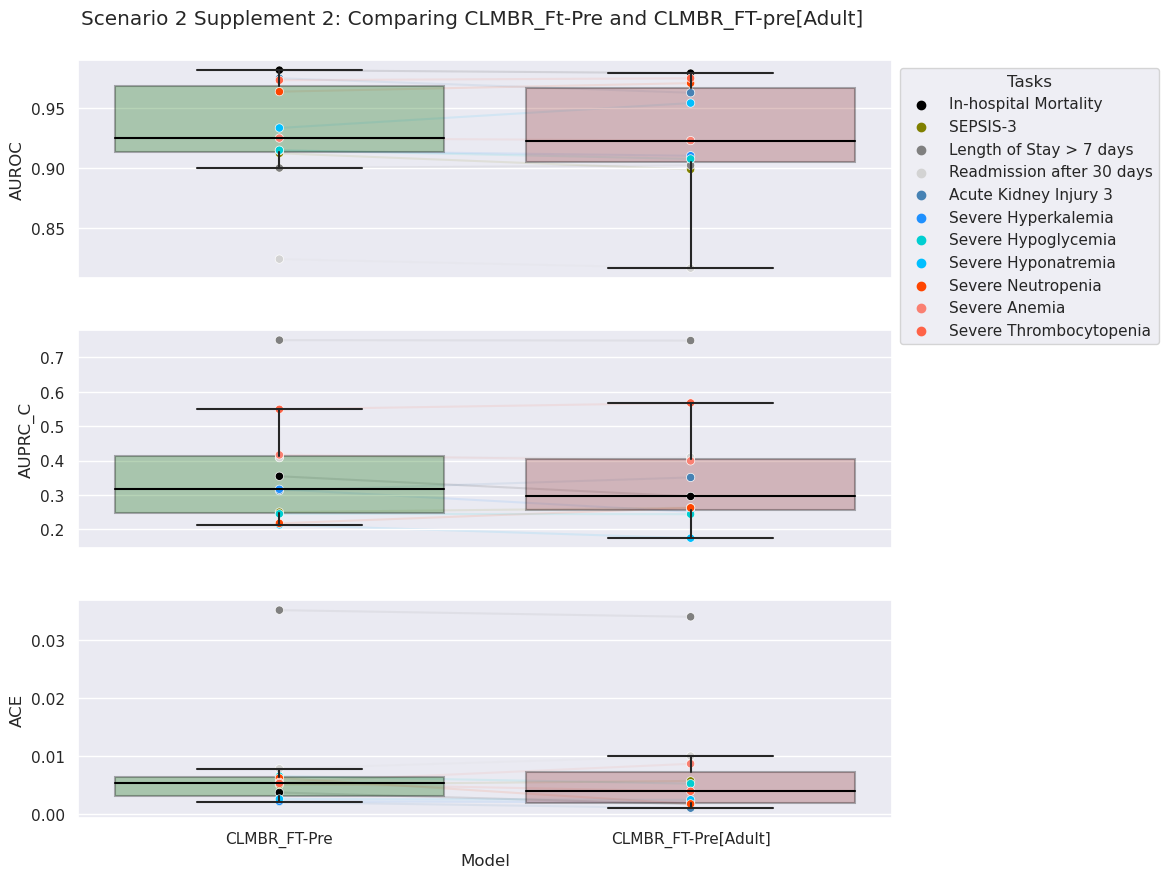

In [32]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(9,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Scenario 2 Supplement 2: Comparing CLMBR_Ft-Pre and CLMBR_FT-pre[Adult]')
for r, metric in enumerate(metrics):
    df = plot_dict['s2s2'][metric]
    df = df.replace({'Tasks':{**titles}})
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours)
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='Tasks',  palette=sns.color_palette(palette_list), ax=axs[r])
    lp = sns.lineplot(x="Model", y="Performance", hue='Tasks', data=df.reset_index(), palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r], zorder=0)
    h,l = sp.axes.get_legend_handles_labels()
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != 0:
        sp.legend_.remove()
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])
        
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
plt.savefig('figures/sc_2_supp_2.png', bbox_inches='tight')

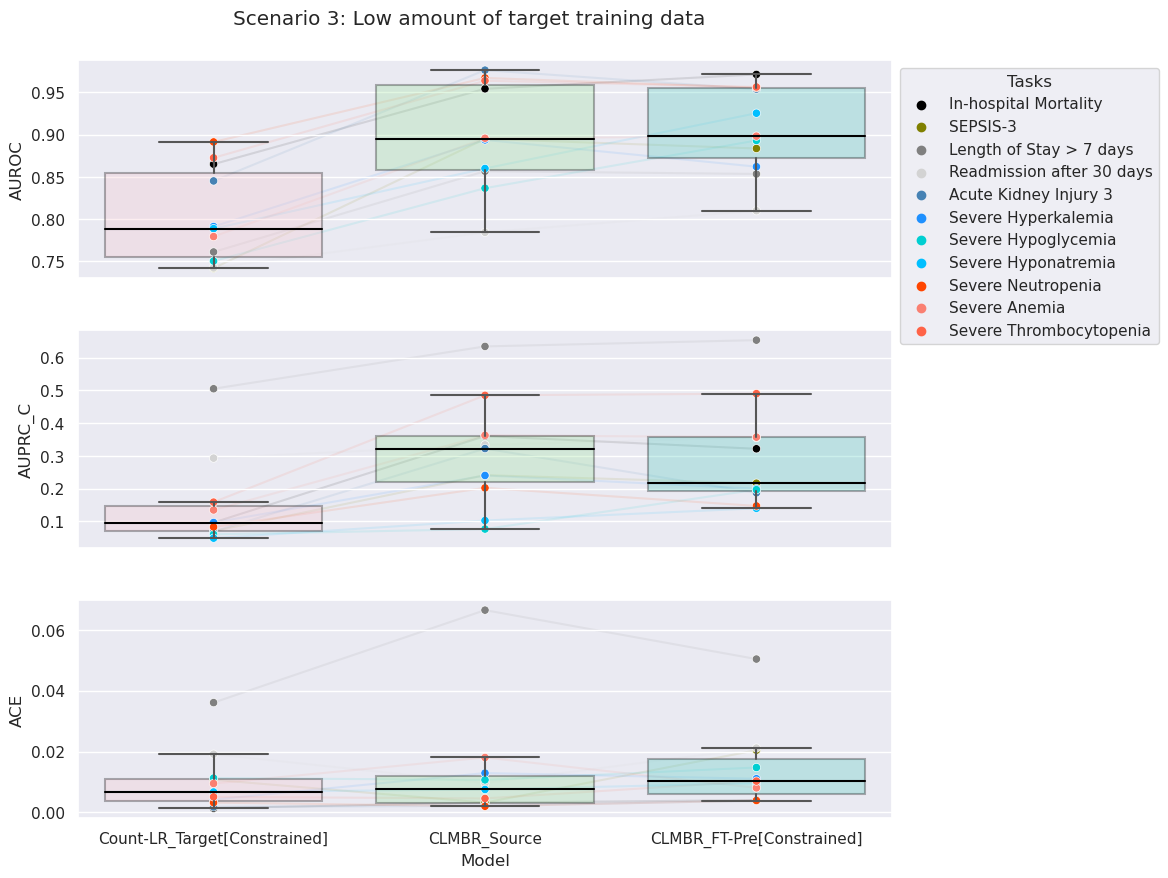

In [15]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(9,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Main figure for Scenario 3
fig.suptitle('Scenario 3: Low amount of target training data ')
for r, metric in enumerate(metrics):
    df = plot_dict['s3m'][metric]
    df = df.replace({'Tasks':{**titles}})
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours)
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='Tasks',  palette=sns.color_palette(palette_list), ax=axs[r])
    lp = sns.lineplot(x="Model", y="Performance", hue='Tasks', data=df.reset_index(), palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r], zorder=0)
    h,l = sp.axes.get_legend_handles_labels()
    
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != 0:
        sp.legend_.remove()
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])
        
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
plt.savefig('figures/sc_3_main.png', bbox_inches='tight')